In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import tensorflow as tf
import tensorflow_datasets as tfds
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.layers import Dropout
from keras.layers import BatchNormalization, Reshape, Conv2DTranspose, Conv2D, Flatten
from keras.layers import LeakyReLU
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import time


In [2]:
Z_DIM = 100
BATCH_SIZE = 1024
EPOCHS = 250


def generate_z(size):
    return tf.random.uniform((size, Z_DIM), -1, 1)



In [3]:
ds = tfds.load("celeb_a", split="train", shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
ds = ds.map(lambda x: (tf.cast(x["image"], tf.float32) - 127.5) / 127.5)
ds = ds.map(lambda x: tf.image.rgb_to_grayscale(x))
ds = ds.map(lambda x: tf.image.resize(x, (32, 32)))

In [4]:
def create_generator():
    generator = Sequential()
    generator.add(Dense(units=256 * 8 * 8, input_dim=Z_DIM, use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Reshape((8, 8, 256)))
    generator.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU())
    generator.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation="tanh"))
    generator.compile()

    return generator


g = create_generator()
g.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16384)             1638400   
                                                                 
 batch_normalization (BatchN  (None, 16384)            65536     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16384)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 128)        5

In [5]:
def create_discriminator():
    discriminator = Sequential()
    discriminator.add(Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[32, 32, 1]))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU())
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return discriminator


d = create_discriminator()
d.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)             

In [6]:
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(Z_DIM,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return gan


gan = create_gan(d, g)
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 32, 32, 1)         2730304   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 214785    
                                                                 
Total params: 2,945,089
Trainable params: 2,697,152
Non-trainable params: 247,937
_________________________________________________________________


In [7]:
def plot_generated_images(generator):
    noise = generate_z(10)
    generated_images = generator.predict(noise, verbose=0)
    generated_images = generated_images.reshape(10, 32, 32)
    plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i + 1)
        plt.imshow(generated_images[i], interpolation="nearest", cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()



2023-08-18 22:08:42.603928: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-18 22:08:46.014572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-18 22:09:56.670318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-08-18 22:09:59.806781: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape 

Epoch: 0, Time: 84.34664511680603, BPS: 1.8969337758298115, Generator Loss: 0.03198659791529572, Discriminator Loss: 0.10153579598647079


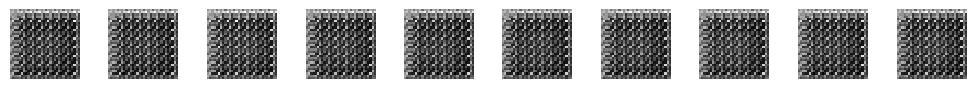

Epoch: 5, Time: 69.08433389663696, BPS: 2.316009882057918, Generator Loss: 0.6913231455679959, Discriminator Loss: 0.6511395073161935
Epoch: 10, Time: 62.784588098526, BPS: 2.5483961087538987, Generator Loss: 0.18785109590012697, Discriminator Loss: 0.709207276315809


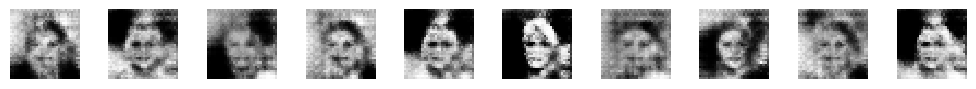

Epoch: 15, Time: 57.56867790222168, BPS: 2.7792891174564445, Generator Loss: 0.14609117554090684, Discriminator Loss: 0.42702773194642935
Epoch: 20, Time: 62.99959993362427, BPS: 2.5396986674292275, Generator Loss: 0.31377238691227993, Discriminator Loss: 0.6198702821941495


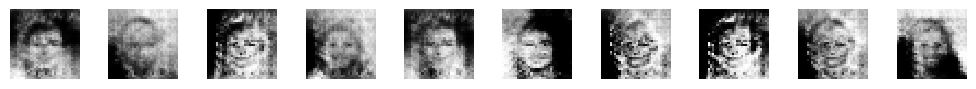

Epoch: 25, Time: 54.82541561126709, BPS: 2.918354529849084, Generator Loss: 0.3974109982731957, Discriminator Loss: 0.5083929210338952
Epoch: 30, Time: 55.25826358795166, BPS: 2.895494530792421, Generator Loss: 0.2935614379228286, Discriminator Loss: 0.45931204722362495


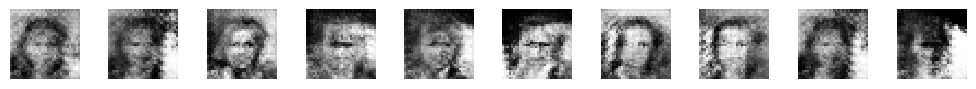

Epoch: 35, Time: 54.80424451828003, BPS: 2.9194819015638793, Generator Loss: 0.6103968912700437, Discriminator Loss: 0.6124437031505993
Epoch: 40, Time: 54.66854929924011, BPS: 2.926728476444572, Generator Loss: 0.532409908636561, Discriminator Loss: 0.5340132428415166


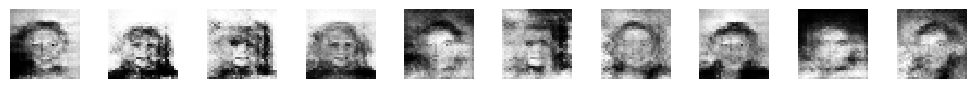

Epoch: 45, Time: 54.60925889015198, BPS: 2.9299060864723394, Generator Loss: 0.4534698374709993, Discriminator Loss: 0.45214172729156304
Epoch: 50, Time: 54.68934869766235, BPS: 2.925615385996342, Generator Loss: 0.5403443385595046, Discriminator Loss: 0.5465888062363151


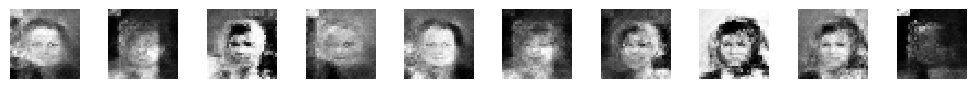

Epoch: 55, Time: 56.12221145629883, BPS: 2.8509211566723205, Generator Loss: 0.5810245937146481, Discriminator Loss: 0.5250520016412316
Epoch: 60, Time: 55.98515272140503, BPS: 2.8579005722498736, Generator Loss: 0.8190534913314963, Discriminator Loss: 0.658070721716251


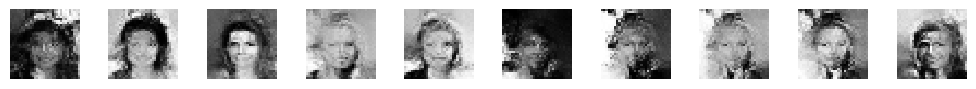

Epoch: 65, Time: 56.296327352523804, BPS: 2.8421036952924266, Generator Loss: 0.8216127014759952, Discriminator Loss: 0.6524500989314145
Epoch: 70, Time: 56.07605051994324, BPS: 2.85326799081716, Generator Loss: 0.8579470384045966, Discriminator Loss: 0.6491155658128127


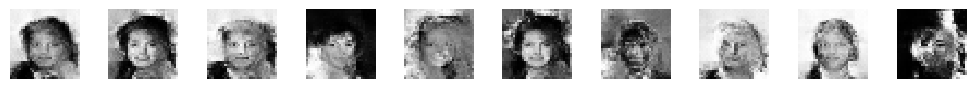

Epoch: 75, Time: 56.1390016078949, BPS: 2.8500684981454856, Generator Loss: 0.8566038143709771, Discriminator Loss: 0.6290738151508307
Epoch: 80, Time: 57.301345348358154, BPS: 2.79225555747941, Generator Loss: 0.8911475029381566, Discriminator Loss: 0.6352829025976313


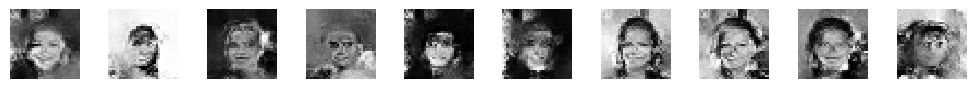

Epoch: 85, Time: 58.33116936683655, BPS: 2.742958897219811, Generator Loss: 0.8656072346669323, Discriminator Loss: 0.6397879352359652
Epoch: 90, Time: 58.7643301486969, BPS: 2.7227401315583277, Generator Loss: 0.9076623043174263, Discriminator Loss: 0.6161192438137606


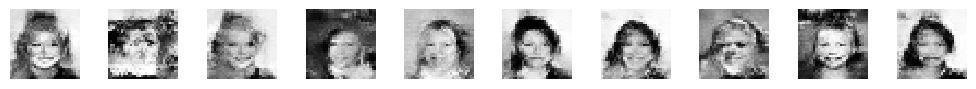

Epoch: 95, Time: 56.380499839782715, BPS: 2.837860615898659, Generator Loss: 0.890649343811491, Discriminator Loss: 0.6086552442994507
Epoch: 100, Time: 56.35157084465027, BPS: 2.8393174777875707, Generator Loss: 0.9086552505973, Discriminator Loss: 0.6059181101667056


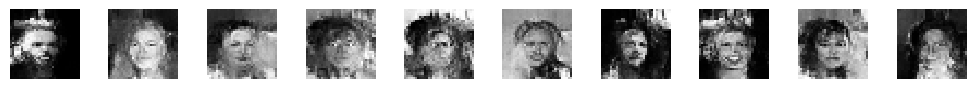

Epoch: 105, Time: 56.64904808998108, BPS: 2.824407565434405, Generator Loss: 0.9626573316706052, Discriminator Loss: 0.6008270800863422
Epoch: 110, Time: 56.073848247528076, BPS: 2.8533800514940286, Generator Loss: 0.9067456549818411, Discriminator Loss: 0.6082738649170354


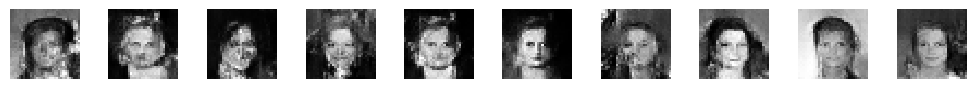

Epoch: 115, Time: 58.04381275177002, BPS: 2.756538421834132, Generator Loss: 0.9152731306897769, Discriminator Loss: 0.5980234877118524
Epoch: 120, Time: 57.98238229751587, BPS: 2.759458884925031, Generator Loss: 0.91503200141139, Discriminator Loss: 0.6177971880390959


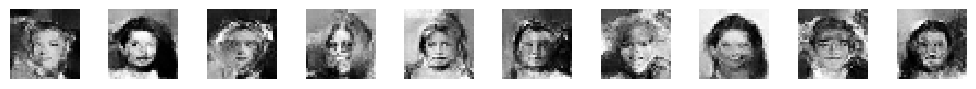

Epoch: 125, Time: 56.64079523086548, BPS: 2.8248190963394277, Generator Loss: 1.0024303827645644, Discriminator Loss: 0.6045641494247148
Epoch: 130, Time: 57.07771849632263, BPS: 2.8031954362420493, Generator Loss: 0.9082645642682441, Discriminator Loss: 0.5988728557742616


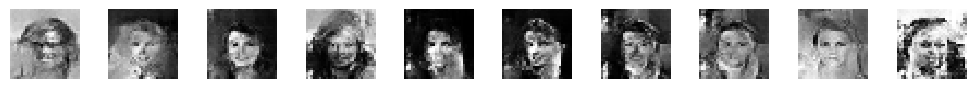

Epoch: 135, Time: 56.75953125953674, BPS: 2.818909819187712, Generator Loss: 0.8981206863181396, Discriminator Loss: 0.5913456880821372
Epoch: 140, Time: 56.86270022392273, BPS: 2.8137953239984608, Generator Loss: 0.7229338567118225, Discriminator Loss: 0.5150089650971335


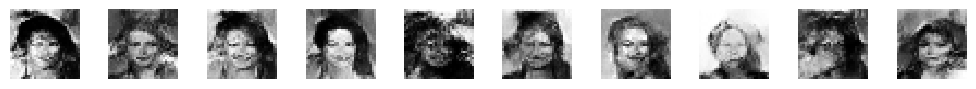

Epoch: 145, Time: 56.662550926208496, BPS: 2.8237345016176136, Generator Loss: 0.8396399752149042, Discriminator Loss: 0.5899704627270969
Epoch: 150, Time: 56.56414866447449, BPS: 2.828646833334011, Generator Loss: 0.7197066475666544, Discriminator Loss: 0.5161739116382299


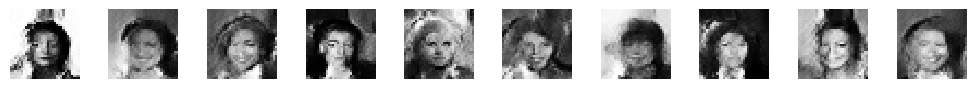

Epoch: 155, Time: 58.245699882507324, BPS: 2.746983903064956, Generator Loss: 0.8688045130960597, Discriminator Loss: 0.596751647925227
Epoch: 160, Time: 56.50561308860779, BPS: 2.8315770992361453, Generator Loss: 0.758493554667107, Discriminator Loss: 0.5604006115745448


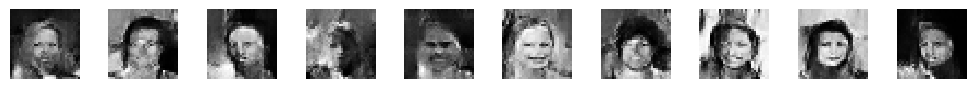

Epoch: 165, Time: 56.59185576438904, BPS: 2.827261941473238, Generator Loss: 0.779276911333297, Discriminator Loss: 0.5277515559826257
Epoch: 170, Time: 57.02132987976074, BPS: 2.805967527193551, Generator Loss: 0.9448061026867081, Discriminator Loss: 0.6196225581678955


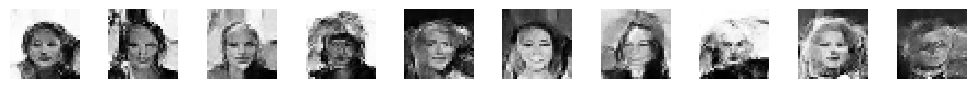

Epoch: 175, Time: 56.943756103515625, BPS: 2.8097900621297764, Generator Loss: 0.834160900715762, Discriminator Loss: 0.5997218512139231
Epoch: 180, Time: 57.23750710487366, BPS: 2.7953698211705715, Generator Loss: 0.9007345051885401, Discriminator Loss: 0.6168123772309261


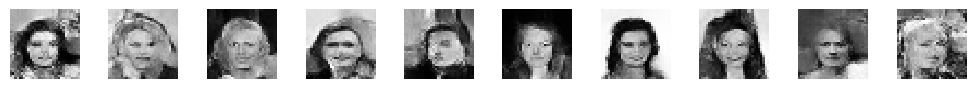

Epoch: 185, Time: 56.83958864212036, BPS: 2.8149394431302013, Generator Loss: 0.8185621143886878, Discriminator Loss: 0.5917102435849747
Epoch: 190, Time: 56.915536403656006, BPS: 2.81118320427043, Generator Loss: 0.7040968072489373, Discriminator Loss: 0.5437112344229746


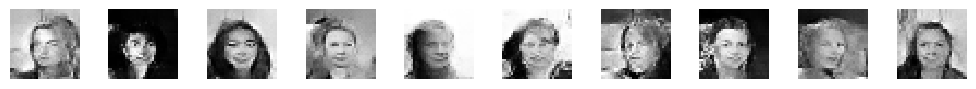

Epoch: 195, Time: 56.50433135032654, BPS: 2.8316413304318373, Generator Loss: 0.7065485967498906, Discriminator Loss: 0.5333701549273617
Epoch: 200, Time: 56.459096908569336, BPS: 2.8339100120412177, Generator Loss: 0.6573073222952069, Discriminator Loss: 0.538074774749624


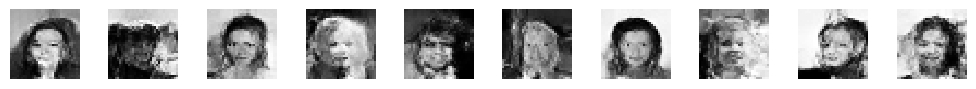

Epoch: 205, Time: 57.95200824737549, BPS: 2.7609051841140646, Generator Loss: 0.7803730229911564, Discriminator Loss: 0.5940787171792684
Epoch: 210, Time: 56.7043993473053, BPS: 2.8216505569528354, Generator Loss: 0.7015630843223266, Discriminator Loss: 0.5487776942223123


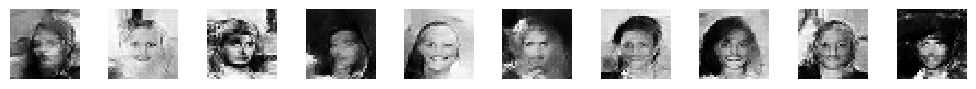

Epoch: 215, Time: 56.62384057044983, BPS: 2.825664921137456, Generator Loss: 0.2609239595842624, Discriminator Loss: 0.33123059027224966
Epoch: 220, Time: 56.77958273887634, BPS: 2.817914332618894, Generator Loss: 0.7373799508285223, Discriminator Loss: 0.5641995143590484


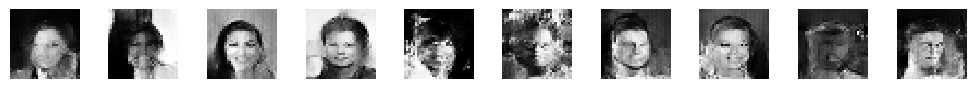

Epoch: 225, Time: 56.96456480026245, BPS: 2.808763668449247, Generator Loss: 0.5210512372307807, Discriminator Loss: 0.4649042513385509
Epoch: 230, Time: 56.8472683429718, BPS: 2.8145591628903888, Generator Loss: 0.40044386839529256, Discriminator Loss: 0.45191566758560686


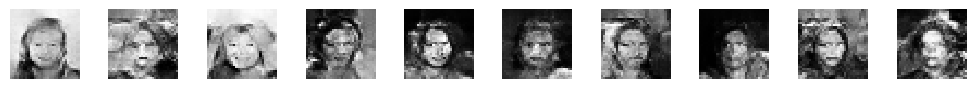

Epoch: 235, Time: 56.91132664680481, BPS: 2.811391148777287, Generator Loss: 0.7633941924234606, Discriminator Loss: 0.577952448583249
Epoch: 240, Time: 56.82020425796509, BPS: 2.8158997682161817, Generator Loss: 0.6289226806388711, Discriminator Loss: 0.5280262863486068


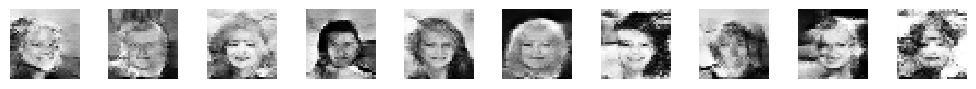

Epoch: 245, Time: 57.2772753238678, BPS: 2.7934289662924487, Generator Loss: 0.7155890983980406, Discriminator Loss: 0.5242993173734197


In [8]:
dlosses = []
glosses = []

for epoch in range(EPOCHS):
    dloss = []
    gloss = []
    t = time.time()
    i = 1
    for batch in ds.batch(BATCH_SIZE):
        i += 1
        batch_size = batch.shape[0]
        noise = generate_z(batch_size)
        generated_images = g.predict(noise, verbose=0)
        X = tf.concat([batch, generated_images], axis=0)
        y_dis = tf.concat([tf.ones(batch_size, dtype=tf.float32), tf.zeros(batch_size, dtype=tf.float32)], axis=0)

        d.trainable = True

        dloss.append(d.train_on_batch(X, y_dis))

        noise = generate_z(batch_size)
        y_gen = tf.ones(batch_size, dtype=tf.float32)
        d.trainable = False
        gloss.append(gan.train_on_batch(noise, y_gen))

    dlosses.append(np.mean(dloss))
    glosses.append(np.mean(gloss))
    dt = time.time() - t
    bps = i / dt
    if epoch % 5 == 0:
        print(
            f"Epoch: {epoch}, Time: {dt}, BPS: {bps}, Generator Loss: {np.mean(gloss)}, Discriminator Loss: {np.mean(dloss)}"
        )
    if epoch % 10 == 0:
        plot_generated_images(g)

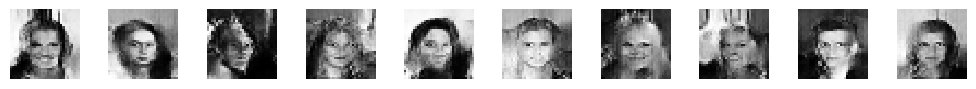

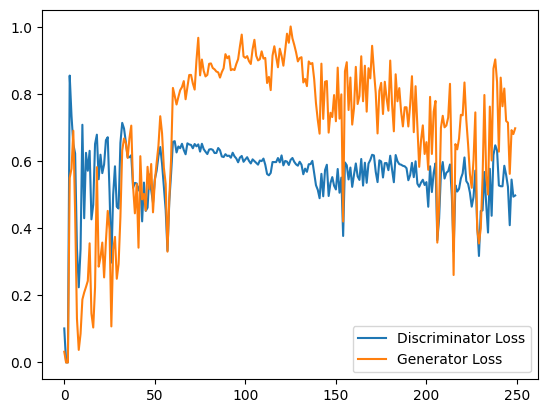

In [9]:
plot_generated_images(g)

plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
plt.legend()
plt.show()

In [10]:
g.save("generator.h5")
d.save("discriminator.h5")
gan.save("gan.h5")
